In [ ]:
#@title Default title text
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [1]:
import pandas as pd
import numpy as np

def to_month_id(year, month):
  return (year - 1996) * 12 + month - 6

n_features = 12
lookback = 3
chosen_stocks = ["INTC"] # "AMZN", "MSFT", "IBM", "INTC", "QCOM", "NVDA", "IBM", "ADBE", "EBAY", "CSCO"

In [2]:
dfFeature = pd.read_csv("./lstm_2004_12.csv")
# dfFeature.loc[dfFeature["return"] == 0, "return"] = 1
dfFeature = dfFeature[dfFeature.QAId.isin(chosen_stocks)]
features = dfFeature.drop(columns=['month_id', 'QAId']).as_matrix()
print(features.shape)

(157, 12)


In [3]:
from sklearn.preprocessing import MinMaxScaler
normalizedFeatures = MinMaxScaler().fit_transform(features) \
                                   .reshape(157, len(chosen_stocks), n_features) \
                                   .reshape(157, len(chosen_stocks) * n_features)
print(normalizedFeatures.shape)

(157, 12)


In [4]:
dfTarget = pd.read_csv("./return_2004_40.csv")
dfTarget["return"] = np.sign(dfTarget["return"])
# dfTarget.loc[dfTarget["return"] == 0, "return"] = 1
dfTarget = dfTarget[dfTarget.QAId.isin(chosen_stocks)]
dfTarget = dfTarget[dfTarget.month_id >= (to_month_id(2004, 1) + lookback)]
targets = MinMaxScaler().fit_transform(dfTarget.drop(columns=['month_id', 'QAId']).as_matrix())
y = targets.reshape(157 - lookback + 1, len(chosen_stocks))
print(y.shape)

(155, 1)


In [5]:
from keras.preprocessing.sequence import TimeseriesGenerator

splittedFeature = normalizedFeatures
print(splittedFeature.shape)

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(157, 12)


In [6]:
from keras.preprocessing.sequence import TimeseriesGenerator

x = np.zeros((157 - lookback + 1, lookback, n_features * len(chosen_stocks)))
y_mock = np.zeros((157, len(chosen_stocks)))

i = 0
for train, test in TimeseriesGenerator(splittedFeature, y_mock, length=lookback, batch_size=1):
  if i > 157 - lookback:
    break
  x[i] = train[0]
  i = i + 1

In [7]:
from sklearn.model_selection import PredefinedSplit

test_months = 26
end_point = 157 - lookback + 1
split_point = 157 - lookback + 1 - test_months

x_train = x[0:split_point - 48].reshape(split_point - 48, lookback, n_features * len(chosen_stocks))
y_train = y[0:split_point - 48].reshape(split_point - 48, len(chosen_stocks))
x_validate = x[split_point - 36:split_point].reshape(36, lookback, n_features * len(chosen_stocks))
y_validate = y[split_point - 36:split_point].reshape(36, len(chosen_stocks))
x_test = x[split_point:end_point].reshape(test_months, lookback, n_features * len(chosen_stocks))
y_test = y[split_point:end_point].reshape(test_months, len(chosen_stocks))

print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)
print(x_test.shape)
print(y_test.shape)

# ps = PredefinedSplit(np.append(np.negative(np.ones(60 * 465)), np.zeros(24 * 465))).split(x_train)

# for train_ids, test_ids in ps:
#   print(str(train_ids) + ", " + str(test_ids))

(81, 3, 12)
(81, 1)
(36, 3, 12)
(36, 1)
(26, 3, 12)
(26, 1)


In [8]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Flatten, CuDNNLSTM
from keras.regularizers import l1_l2, l2
from keras.optimizers import RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

np.random.seed(4103)

def create_model(*param):
    model = Sequential()
    model.add(LSTM(units=256, input_shape=(lookback, n_features * len(chosen_stocks)), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(len(chosen_stocks), activation="relu"))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=0.0), metrics=['accuracy'], *param)
    return model

In [9]:
batch_size=30

model = create_model()
train_score = model.fit(x_train, y_train, validation_data=(x_validate, y_validate), batch_size=batch_size, epochs=200)
print(train_score)

Train on 81 samples, validate on 36 samples
Epoch 1/200
81/81 [==============================] - 2s 26ms/step - loss: 7.9560 - acc: 0.4444 - val_loss: 3.6114 - val_acc: 0.4167
Epoch 2/200
81/81 [==============================] - 0s 727us/step - loss: 3.6887 - acc: 0.4444 - val_loss: 2.8282 - val_acc: 0.4167
Epoch 3/200
81/81 [==============================] - 0s 735us/step - loss: 2.6029 - acc: 0.4444 - val_loss: 2.5410 - val_acc: 0.4167
Epoch 4/200
81/81 [==============================] - 0s 726us/step - loss: 2.4010 - acc: 0.4444 - val_loss: 2.3688 - val_acc: 0.4167
Epoch 5/200
81/81 [==============================] - 0s 742us/step - loss: 2.2531 - acc: 0.4444 - val_loss: 2.2537 - val_acc: 0.4167
Epoch 6/200
81/81 [==============================] - 0s 747us/step - loss: 2.1511 - acc: 0.4444 - val_loss: 2.1718 - val_acc: 0.4167
Epoch 7/200
81/81 [==============================] - 0s 788us/step - loss: 2.0701 - acc: 0.4444 - val_loss: 2.1061 - val_acc: 0.4167
Epoch 8/200
81/81 [=======

Epoch 62/200
81/81 [==============================] - 0s 807us/step - loss: 0.8291 - acc: 0.4444 - val_loss: 0.7988 - val_acc: 0.4167
Epoch 63/200
81/81 [==============================] - 0s 776us/step - loss: 0.8037 - acc: 0.4444 - val_loss: 0.7842 - val_acc: 0.4167
Epoch 64/200
81/81 [==============================] - 0s 769us/step - loss: 0.8075 - acc: 0.4444 - val_loss: 0.7706 - val_acc: 0.4167
Epoch 65/200
81/81 [==============================] - 0s 739us/step - loss: 0.7690 - acc: 0.4444 - val_loss: 0.7584 - val_acc: 0.4167
Epoch 66/200
81/81 [==============================] - 0s 766us/step - loss: 0.7799 - acc: 0.4444 - val_loss: 0.7462 - val_acc: 0.4167
Epoch 67/200
81/81 [==============================] - 0s 767us/step - loss: 0.7731 - acc: 0.4444 - val_loss: 0.7351 - val_acc: 0.4167
Epoch 68/200
81/81 [==============================] - 0s 776us/step - loss: 0.7479 - acc: 0.4321 - val_loss: 0.7250 - val_acc: 0.4167
Epoch 69/200
81/81 [==============================] - 0s 748us

Epoch 123/200
81/81 [==============================] - 0s 742us/step - loss: 0.6968 - acc: 0.5309 - val_loss: 0.6682 - val_acc: 0.5833
Epoch 124/200
81/81 [==============================] - 0s 768us/step - loss: 0.7000 - acc: 0.5185 - val_loss: 0.6680 - val_acc: 0.5833
Epoch 125/200
81/81 [==============================] - 0s 765us/step - loss: 0.7036 - acc: 0.4938 - val_loss: 0.6680 - val_acc: 0.5833
Epoch 126/200
81/81 [==============================] - 0s 782us/step - loss: 0.6919 - acc: 0.5185 - val_loss: 0.6680 - val_acc: 0.5833
Epoch 127/200
81/81 [==============================] - 0s 749us/step - loss: 0.7018 - acc: 0.5309 - val_loss: 0.6680 - val_acc: 0.5833
Epoch 128/200
81/81 [==============================] - 0s 799us/step - loss: 0.6841 - acc: 0.5432 - val_loss: 0.6677 - val_acc: 0.5833
Epoch 129/200
81/81 [==============================] - 0s 782us/step - loss: 0.6786 - acc: 0.5679 - val_loss: 0.6676 - val_acc: 0.5833
Epoch 130/200
81/81 [==============================] - 

Epoch 184/200
81/81 [==============================] - 0s 916us/step - loss: 0.6795 - acc: 0.5556 - val_loss: 0.6596 - val_acc: 0.5833
Epoch 185/200
81/81 [==============================] - 0s 863us/step - loss: 0.6796 - acc: 0.5432 - val_loss: 0.6600 - val_acc: 0.5833
Epoch 186/200
81/81 [==============================] - 0s 803us/step - loss: 0.6973 - acc: 0.4568 - val_loss: 0.6600 - val_acc: 0.5833
Epoch 187/200
81/81 [==============================] - 0s 861us/step - loss: 0.6771 - acc: 0.5556 - val_loss: 0.6595 - val_acc: 0.5833
Epoch 188/200
81/81 [==============================] - 0s 821us/step - loss: 0.6712 - acc: 0.5679 - val_loss: 0.6597 - val_acc: 0.5833
Epoch 189/200
81/81 [==============================] - 0s 860us/step - loss: 0.6820 - acc: 0.5556 - val_loss: 0.6600 - val_acc: 0.5833
Epoch 190/200
81/81 [==============================] - 0s 876us/step - loss: 0.6860 - acc: 0.5309 - val_loss: 0.6599 - val_acc: 0.5833
Epoch 191/200
81/81 [==============================] - 

26/26 [==============================] - 0s 182us/step
loss: 0.6840814352035522
acc: 0.6153846383094788


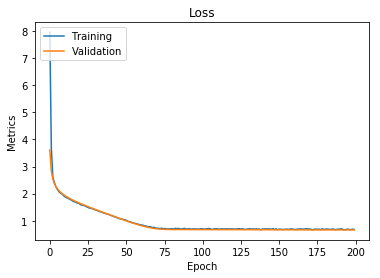

In [15]:
import matplotlib.pyplot as plt

test_score = model.evaluate(x_test, y_test, batch_size=batch_size)
for i, mn in enumerate(model.metrics_names):
  print(mn + ": " + str(test_score[i]))

plt.plot(train_score.history["loss"])
plt.plot(train_score.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

In [16]:
from sklearn.metrics import precision_score, recall_score, classification_report

def threshold_tester(result, target, a, b):
  for t in np.arange(a, b + 0.05, 0.05):
    print("thresholder: " + str(t))
    print(classification_report(target, (result >= t).astype(int)))

In [17]:
result = model.predict(x_test, batch_size=batch_size)
print(result)
threshold_tester(result, y_test, 0.1, 0.9)

[[0.51044583]
 [0.48725224]
 [0.45726198]
 [0.44539204]
 [0.48299208]
 [0.5422576 ]
 [0.5420239 ]
 [0.53090924]
 [0.5306036 ]
 [0.54211646]
 [0.56266516]
 [0.5420735 ]
 [0.48192263]
 [0.4790198 ]
 [0.4625235 ]
 [0.52341586]
 [0.53152454]
 [0.52451056]
 [0.57180303]
 [0.6248308 ]
 [0.61516225]
 [0.5838981 ]
 [0.57473737]
 [0.47778383]
 [0.47592115]
 [0.52530044]]
thresholder: 0.1
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        11
        1.0       0.58      1.00      0.73        15

avg / total       0.33      0.58      0.42        26

thresholder: 0.15000000000000002
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        11
        1.0       0.58      1.00      0.73        15

avg / total       0.33      0.58      0.42        26

thresholder: 0.20000000000000004
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        11
        1.0    

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
import math

buy_list = []
sell_list = []

midpt = (max(map(lambda x: x[0], result)) + min(map(lambda x: x[0], result))) / 2

for i, r in enumerate(result):
  buy_or_sell = 1 if r.item() > midpt * 1.05 else (-1 if r.item() < midpt * 0.95 else 0)
  if r.item() > midpt * 1.05:
    buy_list.append({'month_id': i + 223, 'QAId': chosen_stocks[0]})
  if r.item() < midpt * 0.95:
    sell_list.append({'month_id': i + 223, 'QAId': chosen_stocks[0]})
  print(str(y_test[i].item()) + ": " + str(buy_or_sell))
  if (math.fabs(buy_or_sell - y_test[i].item()) == 2) or (buy_or_sell - y_test[i].item() == 1):
    print("Hey")
print(buy_list)
print(sell_list)

1.0: 0
0.0: -1
1.0: -1
Hey
1.0: -1
Hey
0.0: -1
0.0: 0
0.0: 0
1.0: 0
1.0: 0
1.0: 0
0.0: 1
Hey
0.0: 0
0.0: -1
1.0: -1
Hey
0.0: -1
1.0: 0
1.0: 0
1.0: 0
1.0: 1
1.0: 1
0.0: 1
Hey
1.0: 1
1.0: 1
1.0: -1
Hey
0.0: -1
0.0: 0
[{'month_id': 233, 'QAId': 'INTC'}, {'month_id': 241, 'QAId': 'INTC'}, {'month_id': 242, 'QAId': 'INTC'}, {'month_id': 243, 'QAId': 'INTC'}, {'month_id': 244, 'QAId': 'INTC'}, {'month_id': 245, 'QAId': 'INTC'}]
[{'month_id': 224, 'QAId': 'INTC'}, {'month_id': 225, 'QAId': 'INTC'}, {'month_id': 226, 'QAId': 'INTC'}, {'month_id': 227, 'QAId': 'INTC'}, {'month_id': 235, 'QAId': 'INTC'}, {'month_id': 236, 'QAId': 'INTC'}, {'month_id': 237, 'QAId': 'INTC'}, {'month_id': 246, 'QAId': 'INTC'}, {'month_id': 247, 'QAId': 'INTC'}]


In [28]:
dfBuy = pd.DataFrame(buy_list, columns=["month_id", "QAId"])
dfSell = pd.DataFrame(sell_list, columns=["month_id", "QAId"])
dfBuy.head(5)
dfSell.head(5)

,month_id,QAId
0,224,INTC
1,225,INTC
2,226,INTC
3,227,INTC
4,235,INTC


In [29]:
# from google.colab import files

filename_base = "_".join([stock.lower() for stock in chosen_stocks])
# filename_model = "./" + filename_base + "_model.h5"
# filename_weights = "./" + filename_base + "_weights.h5"
filename_output_buy = "./" + filename_base + "_output_buy.h5"
filename_output_sell = "./" + filename_base + "_output_sell.h5"

# model.save(filename_model)
# model.save_weights(filename_weights)
dfBuy.to_csv(filename_output_buy, index=False)
dfSell.to_csv(filename_output_sell, index=False)

# files.download(filename_model)
# files.download(filename_weights)
# files.download(filename_output_buy)
# files.download(filename_output_sell)